In [1]:
import torch
import torchvision
import numpy as np
from sklearn.model_selection import StratifiedKFold
from LogisticRegression import LogisticRegression
from sklearn.metrics import confusion_matrix, auc
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

train_images_tensor = train_dataset.data
train_labels_tensor = train_dataset.targets
test_images_tensor = test_dataset.data
test_labels_tensor = test_dataset.targets

train_mask = (train_labels_tensor == 6) | (train_labels_tensor == 8)
test_mask = (test_labels_tensor == 6) | (test_labels_tensor == 8)

train_images_tensor = train_images_tensor[train_mask]
train_labels_tensor = train_labels_tensor[train_mask]
test_images_tensor = test_images_tensor[test_mask]
test_labels_tensor = test_labels_tensor[test_mask]

all_images = torch.cat((train_images_tensor, test_images_tensor), dim=0).numpy().reshape(-1, 28*28) / 255.0
all_labels = torch.cat((train_labels_tensor, test_labels_tensor), dim=0)
all_labels1 = np.where(all_labels.numpy() == 6, 0, 1)
all_labels2 = all_labels1[:,np.newaxis]


--- Fold 1/10 ---
Training with learning rate 0.2
step 1: 0.5247419165572975
step 2: 0.39031826344194115
step 3: 0.3172465592407177
step 4: 0.2715209744453878
step 5: 0.24006015811724685
step 6: 0.2169690217239484
step 7: 0.19921545686396902
step 8: 0.185085669556547
step 9: 0.17353686459042414
step 10: 0.1638963071429081
step 100: 0.05861871519491886
step 200: 0.047270789807754135
step 300: 0.04233676700236335
step 400: 0.039358772408315854
step 500: 0.037277891185536934
step 600: 0.03569752152081769
step 700: 0.03443144173014366
Training finished with lr: 0.2 and threshold: 1e-05
Fold 1 finished.

--- Fold 2/10 ---
Training with learning rate 0.2
step 1: 0.8181269969020472
step 2: 0.534181321232102
step 3: 0.40321119714155984
step 4: 0.328514328941649
step 5: 0.2772843982093153
step 6: 0.24253512455616835
step 7: 0.21863531285955418
step 8: 0.20095108749568402
step 9: 0.1869486397886722
step 10: 0.17548275768715899
step 100: 0.05970082310520716
step 200: 0.04770010628641796
step 300

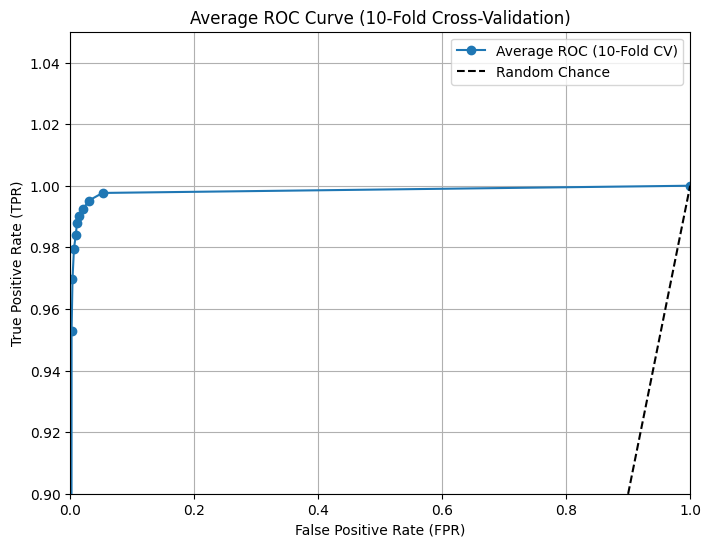

In [3]:


n_splits = 10
k_fold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
thresholds = np.linspace(0, 1, 11)
all_fold_tprs = []
all_fold_fprs = []
fold_num = 1
for train_idx, val_idx in k_fold.split(all_images, all_labels1):
    print(f"\n--- Fold {fold_num}/{n_splits} ---")
    X_train, X_val = all_images[train_idx], all_images[val_idx]
    y_train2, y_val1 = all_labels2[train_idx], all_labels1[val_idx]

    logistic_cv = LogisticRegression()
    logistic_cv.fit(X_train, y_train2)
    logistic_cv.train()

    y_pred = logistic_cv.predict_proba(X_val)

    tprs_current_fold = []
    fprs_current_fold = []

    for threshold in thresholds:
        y_pred_binary = (y_pred >= threshold).astype(int).flatten()

        tn, fp, fn, tp = confusion_matrix(y_val1, y_pred_binary, labels=[0, 1]).ravel()

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0

        tprs_current_fold.append(tpr)
        fprs_current_fold.append(fpr)

    all_fold_tprs.append(tprs_current_fold)
    all_fold_fprs.append(fprs_current_fold)

    print(f"Fold {fold_num} finished.")
    fold_num += 1

mean_tpr = np.mean(all_fold_tprs, axis=0)
mean_fpr = np.mean(all_fold_fprs, axis=0)

print("\n--- Averaged Results ---")
results_dict = {
    'Threshold': thresholds,
    'Mean FPR': mean_fpr,
    'Mean TPR': mean_tpr
}
table = pd.DataFrame(results_dict)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
print(table.to_string(index=False))

average_auc = auc(mean_fpr, mean_tpr)
print(f"\nAverage Area Under Curve (AUC): {average_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, marker='o', linestyle='-', label=f'Average ROC (10-Fold CV)')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance') # Diagonal line

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Average ROC Curve (10-Fold Cross-Validation)')
plt.legend()
plt.grid(True)
plt.xlim([0.0, 1.0])
plt.ylim([0.9, 1.05])
plt.show()
